In [1]:
import pandas as pd
import numpy as np
import pickle #To serialize objects for permanent storage
import matplotlib.pyplot as plt
#from tensorflow.python.framework import ops
#tf.compat.v1.disable_eager_execution()
from scipy import stats
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.preprocessing import StandardScaler,LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [2]:
df=pd.read_csv("E:\cowdata.csv")

In [3]:
df.head()

,X,Y,Z,Label
0,-0.8,0.2,0.2,Feeding
1,-0.9,0.1,0.2,Feeding
2,-0.9,0.0,0.3,Feeding
3,-0.8,-0.1,0.4,Feeding
4,-1.1,-0.2,0.5,Feeding


In [4]:
df.shape

(22110, 4)

In [5]:
df.isnull().sum()

X        0
Y        0
Z        0
Label    0
dtype: int64

In [6]:
df["Label"].value_counts()

Normlwlk     4434
Lying        4392
Feeding      3684
Activewlk    3102
Standing     2712
Lyingdwn     1962
Stadingup    1824
Name: Label, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22110 entries, 0 to 22109
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       22110 non-null  float64
 1   Y       22110 non-null  float64
 2   Z       22110 non-null  float64
 3   Label   22110 non-null  object 
dtypes: float64(3), object(1)
memory usage: 691.1+ KB


In [8]:
countOfActivity=df["Label"].value_counts()
countOfActivity

Normlwlk     4434
Lying        4392
Feeding      3684
Activewlk    3102
Standing     2712
Lyingdwn     1962
Stadingup    1824
Name: Label, dtype: int64

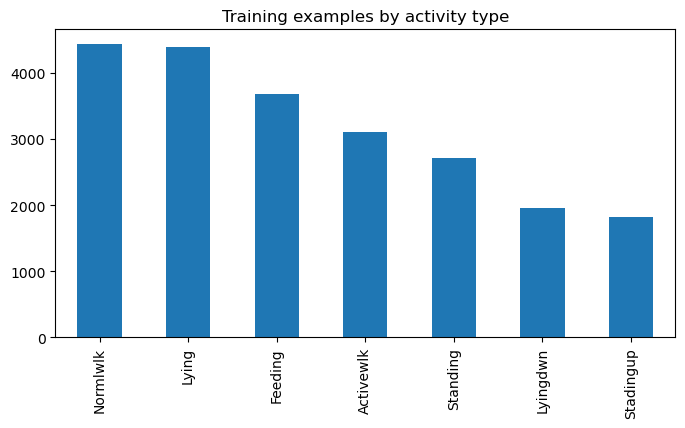

In [9]:
countOfActivity.plot(kind="bar",title="Training examples by activity type",figsize=(8,4));

In [10]:
def plot_activity(activity,df):
    extractRowsOfActivity=(df["Label"]==activity)#output will be true/false
    data=df[extractRowsOfActivity]#it will give only rows corresponding to specific activity
    data=data[["X","Y","Z"]]#only select rows corresponding to x,y and z axis
    data=data[:200]#limit the number of rows to initial 200 for plotting
    ax=data.plot(subplots=True,figsize=(8,4),title=activity)#plotting individual column of dataframe
    

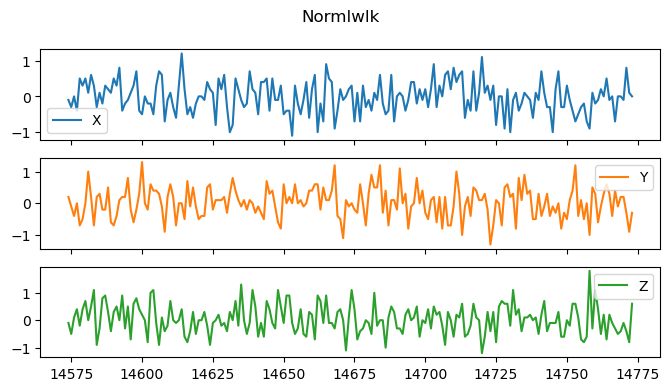

In [11]:
plot_activity("Normlwlk",df)

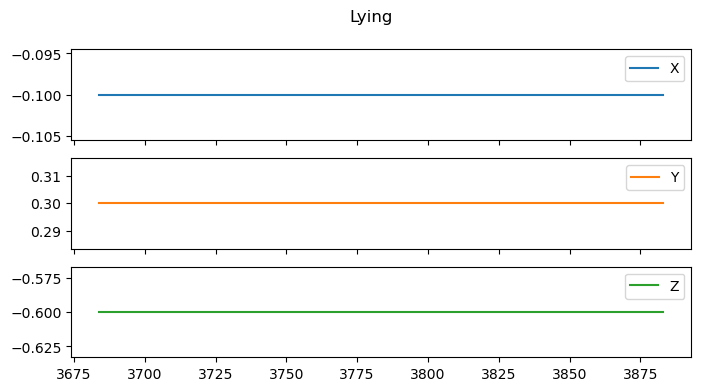

In [12]:
plot_activity("Lying",df)

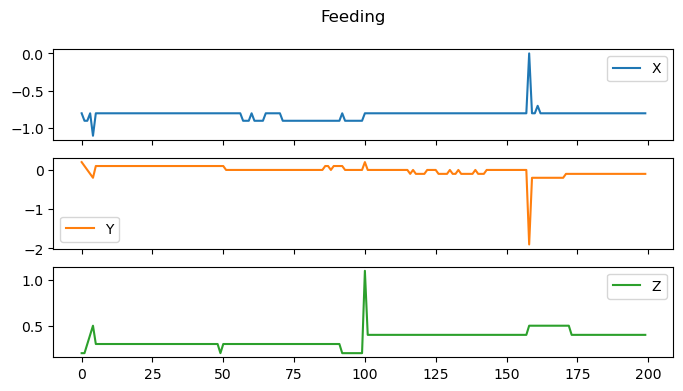

In [13]:
plot_activity("Feeding",df)

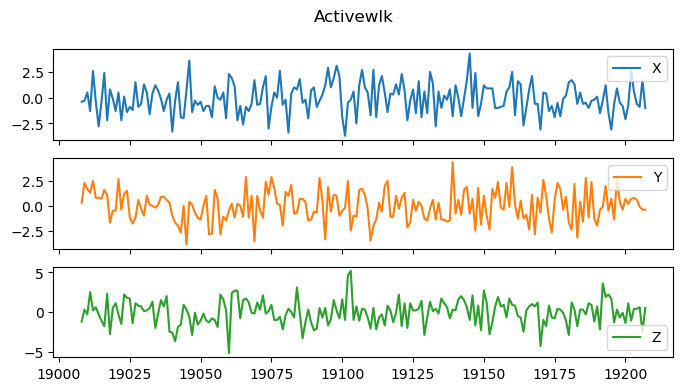

In [14]:
plot_activity("Activewlk",df)

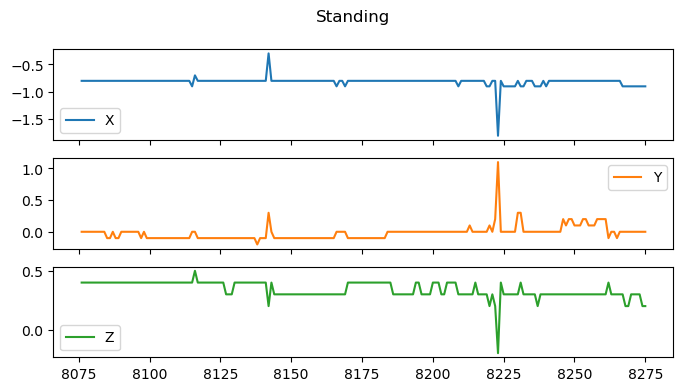

In [15]:
plot_activity("Standing",df)

In [16]:
df["Label"].value_counts()

Normlwlk     4434
Lying        4392
Feeding      3684
Activewlk    3102
Standing     2712
Lyingdwn     1962
Stadingup    1824
Name: Label, dtype: int64

In [17]:
Normlwlk=df[df["Label"]=="Normlwlk"].head(1824).copy()    
Lying=df[df["Label"]=="Lying"].head(1824).copy()   
Feeding=df[df["Label"]=="Feeding"].head(1824).copy()      
Activewlk=df[df["Label"]=="Activewlk"].head(1824).copy()      
Standing=df[df["Label"]=="Standing"].head(1824).copy()     
Lyingdwn=df[df["Label"]=="Lyingdwn"].head(1824).copy()    
Stadingup=df[df["Label"]=="Stadingup"].head(1824).copy()

In [18]:
balanced_data=pd.DataFrame()
balanced_data=balanced_data.append([Normlwlk,Lying,Feeding,Activewlk,Standing,Lyingdwn,Stadingup])
balanced_data.shape

C:\Users\SATVIK\AppData\Local\Temp\ipykernel_25152\3685685541.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_data=balanced_data.append([Normlwlk,Lying,Feeding,Activewlk,Standing,Lyingdwn,Stadingup])


(12768, 4)

In [19]:
balanced_data["Label"].value_counts()

Normlwlk     1824
Lying        1824
Feeding      1824
Activewlk    1824
Standing     1824
Lyingdwn     1824
Stadingup    1824
Name: Label, dtype: int64

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
label=LabelEncoder()
balanced_data["label"]=label.fit_transform(balanced_data["Label"])
df.head()

,X,Y,Z,Label
0,-0.8,0.2,0.2,Feeding
1,-0.9,0.1,0.2,Feeding
2,-0.9,0.0,0.3,Feeding
3,-0.8,-0.1,0.4,Feeding
4,-1.1,-0.2,0.5,Feeding


In [22]:
label.classes_

array(['Activewlk', 'Feeding', 'Lying', 'Lyingdwn', 'Normlwlk',
       'Stadingup', 'Standing'], dtype=object)

In [23]:
X=balanced_data[["X","Y","Z"]]
y=balanced_data["label"]

In [24]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

scaled_X=pd.DataFrame(data=X,columns=["X","Y","Z"])
scaled_X['label']=y.values
scaled_X

,X,Y,Z,label
0,0.162629,0.187346,-0.103521,4
1,-0.064902,-0.178987,-0.571318,4
2,0.276395,-0.545319,0.130377,4
3,-0.178668,-0.056876,0.481224,4
4,0.845223,-0.911652,-0.220470,4
...,...,...,...,...
12763,-1.316324,-0.301098,-1.506910,5
12764,-1.771386,1.042122,-2.442503,5
12765,1.186520,-1.888539,0.247326,5
12766,-0.861261,-1.766428,-2.559452,5


In [25]:
Fs=20
frame_size=Fs*4 #80
hop_size=Fs*2 #40

In [26]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['X'].values[i: i + frame_size]
        y = df['Y'].values[i: i + frame_size]
        z = df['Z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

X.shape, y.shape

C:\Users\SATVIK\AppData\Local\Temp\ipykernel_25152\2438733731.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label'][i: i + frame_size])[0][0]


((318, 80, 3), (318,))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [28]:
X_train.shape, X_test.shape

((254, 80, 3), (64, 80, 3))

In [29]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

In [30]:
X_train = X_train.reshape(254, 80, 3, 1)
X_test = X_test.reshape(64, 80, 3, 1)

In [31]:
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

In [32]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

In [33]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 50, validation_data= (X_test, y_test), verbose=1)

Epoch 1/50
8/8 [==============================] - 0s 21ms/step - loss: 1.7921 - accuracy: 0.1850 - val_loss: 1.6614 - val_accuracy: 0.2344
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 1.5909 - accuracy: 0.3937 - val_loss: 1.5241 - val_accuracy: 0.4375
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 1.4092 - accuracy: 0.5079 - val_loss: 1.3007 - val_accuracy: 0.3906
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 1.2210 - accuracy: 0.5512 - val_loss: 1.1078 - val_accuracy: 0.4375
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 1.0154 - accuracy: 0.5394 - val_loss: 1.0408 - val_accuracy: 0.4375
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.8673 - accuracy: 0.6024 - val_loss: 1.0051 - val_accuracy: 0.4531
Epoch 7/50
8/8 [==============================] - 0s 10ms/step - loss: 0.7616 - accuracy: 0.6575 - val_loss: 1.0259 - val_accuracy: 0.4844
Epoch 8/50
8/8 [===============

In [34]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

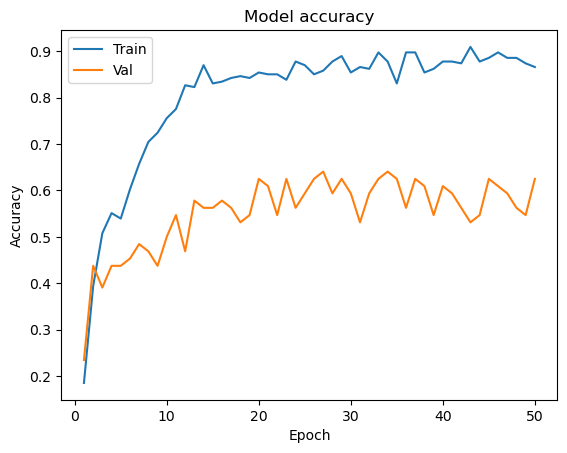

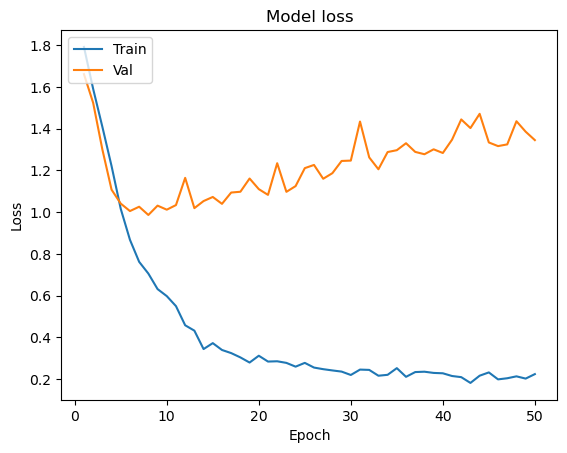

In [35]:
plot_learningCurve(history,50)

In [36]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [37]:
y_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot: xlabel='predicted label', ylabel='true label'>)

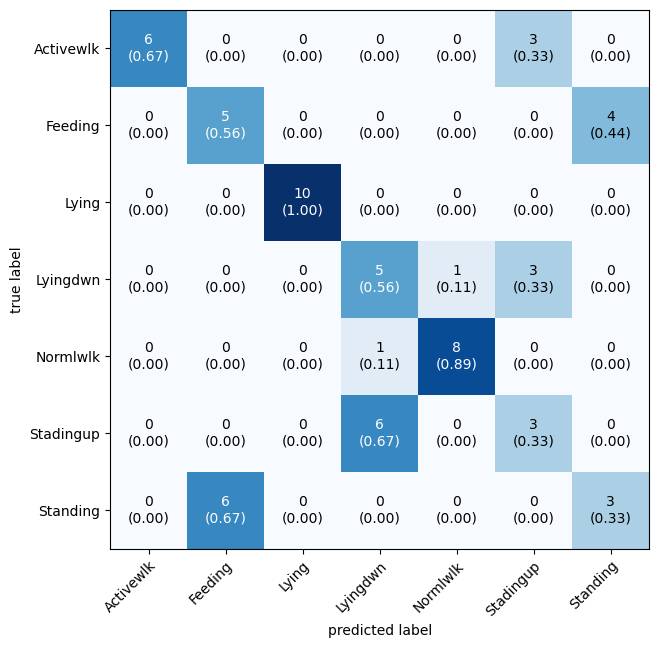

In [40]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))